# Time Series Forecasting with XGBoost
This video is a continuation of the previous video on the topic where <a href="https://www.youtube.com/@robmulla" target="_blank">Rob Mulla</a> covered time series forecasting with xgboost. In this video Rob covers more advanced methods such as outlier removal, time series cross validation, lag features, and a bonus feature! The video tutorial can be found in <a href="https://www.youtube.com/watch?v=z3ZnOW-S550" target="_blank">here</a>. We walk through this project in a kaggle notebook (<a href="https://www.kaggle.com/code/robikscube/pt2-time-series-forecasting-with-xgboost/notebook" target="_blank">link</a>) that you can copy and explore while watching.
### Predicting energy consumption
We will use XGBoost algorithm as it is considered one of the best for tabular data and even time series problems like this. We are using an hourly energy consumption dataset from Kaggle.

In [1]:
import pandas as pd
import numpy as np  
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [2]:
# Importing the dataset
df = pd.read_csv('C:/Users/Jorge Payà/Desktop/4Geeks/DSML Bootcamp/Time-Series-projects/data/raw/PJME_hourly.csv')
df.head()

,Datetime,PJME_MW
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0


In [3]:
# With pandas is very common to set our index to be a datetime object
df = df.set_index('Datetime') # Setting the index to be the datetime
df.index = pd.to_datetime(df.index) # Converting the index to a datetime index
df.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


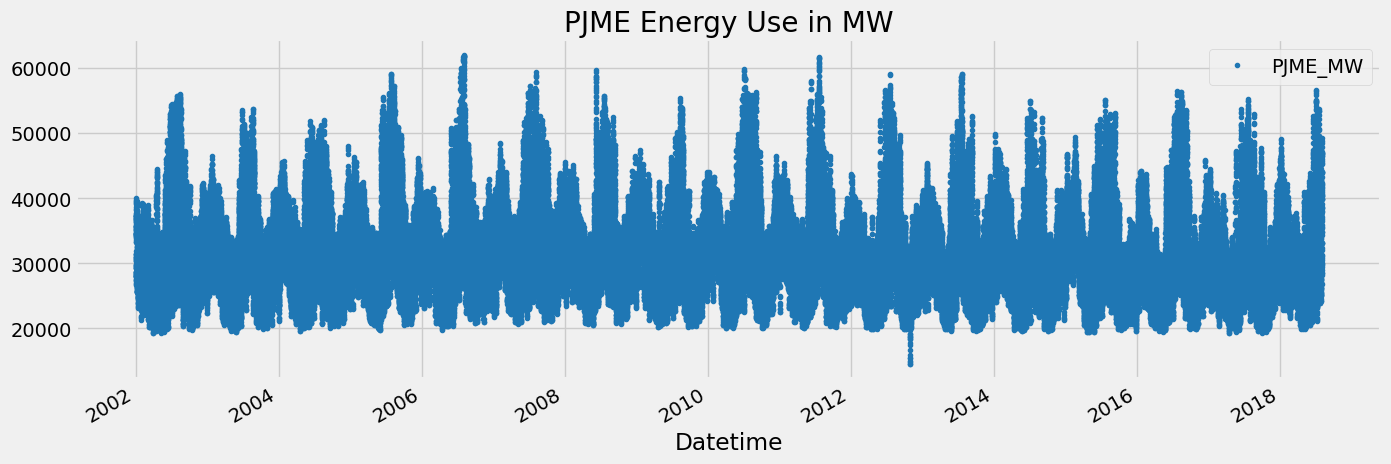

In [4]:
# Let's visualize the data
df.plot(style='.', 
        figsize=(15,5), 
        color=color_pal[0], 
        title='PJME Energy Use in MW')
plt.show()

<div class="alert alert-block alert-info">
<b>Note:</b> We see in the historic data an area in 2012 that looks like an outlier, the values are really low. It might be a blackout or there might have been some problems with the sensors at that moment...the problem is that the model is going to learn these sort of outliers unless we remove them so we need to be pretty careful when removing outliers and not just removing things that we think are wrong even though they may be legitimate values, just legitimate outliers...let's check at the histogram of this megawatt data:</div>

<Axes: title={'center': 'PJME_MW Histogram'}, ylabel='Frequency'>

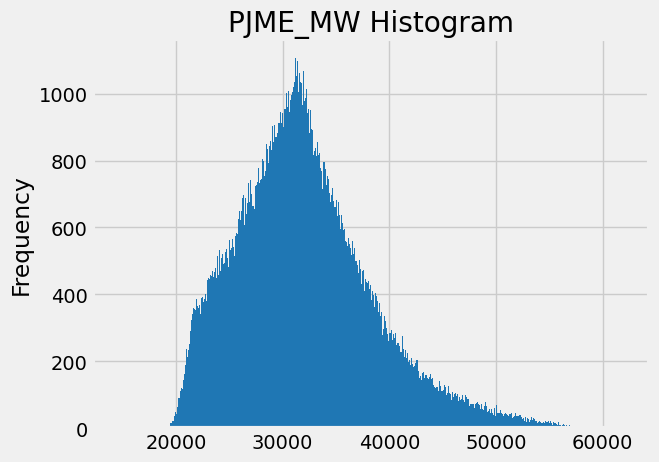

In [5]:
df['PJME_MW'].plot(kind='hist', bins=500, color=color_pal[0], title='PJME_MW Histogram')

<p style="color: pink">Most of the time the values are between 20k and then peak at past 50k. We are checking now when the values are way lower than these values and see if there are extreme outliers that we'd want to remove so let's query our data:</p>

<Axes: title={'center': 'Outliers'}, xlabel='Datetime'>

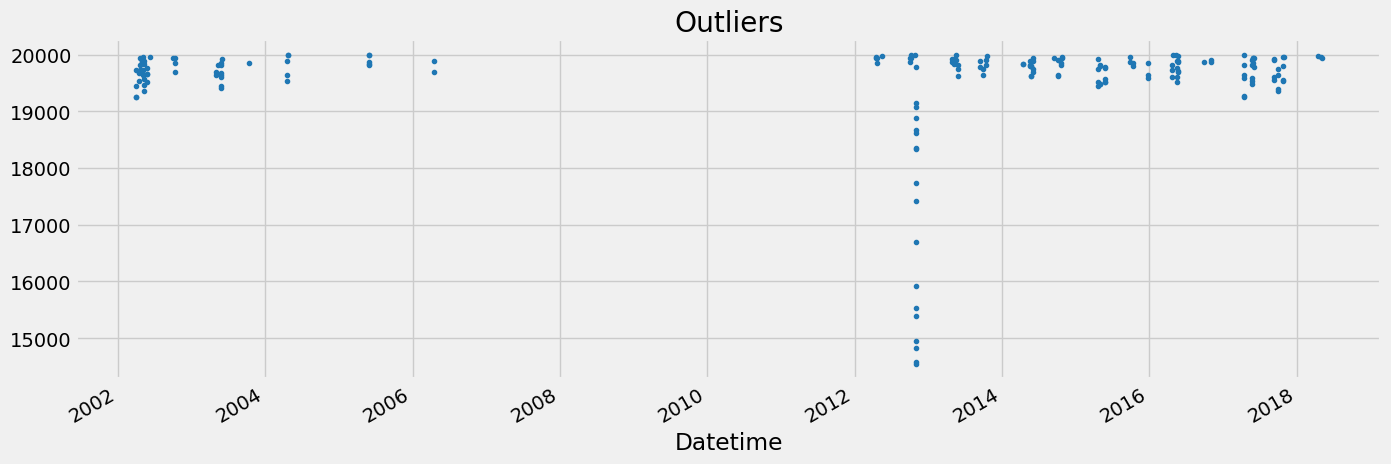

In [6]:
df.query('PJME_MW < 20_000')['PJME_MW'] \
    .plot(style='.',
          figsize=(15, 5),
          color=color_pal[0],
          title='Outliers')

<p style="color: pink">We see that the values do get under 20k sometimes but the area in 2012-2014 definitely doesn't look like they are legitimate and if we actually find a better thresholding maby less than 19k as see see below:</p>

<Axes: title={'center': 'Outliers'}, xlabel='Datetime'>

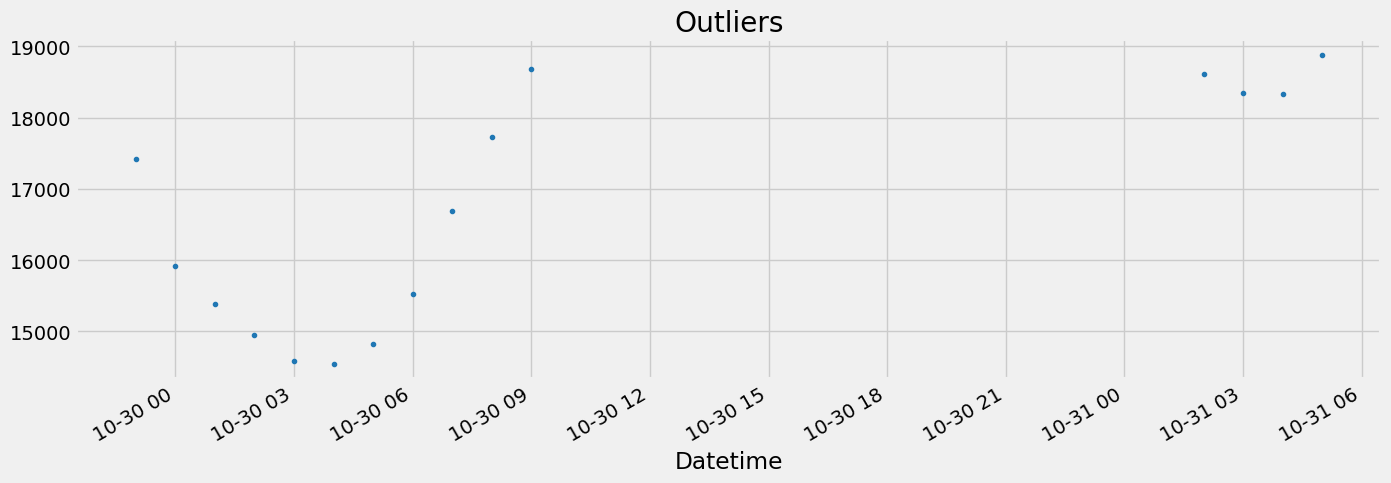

In [7]:
df.query('PJME_MW < 19_000')['PJME_MW'] \
    .plot(style='.',
          figsize=(15, 5),
          color=color_pal[0],
          title='Outliers')

In [8]:
df = df.query('PJME_MW > 19_000').copy() # Removing the outliers from the dataset, with .copy() we are creating a new dataframe

## Train / Test Split
For this case we are going to split the data on the date January 2015 and have everything prior to January 2015 be our training data and keep our test data as the following dates. We can do that by finding where it's less than January 1st 2015:

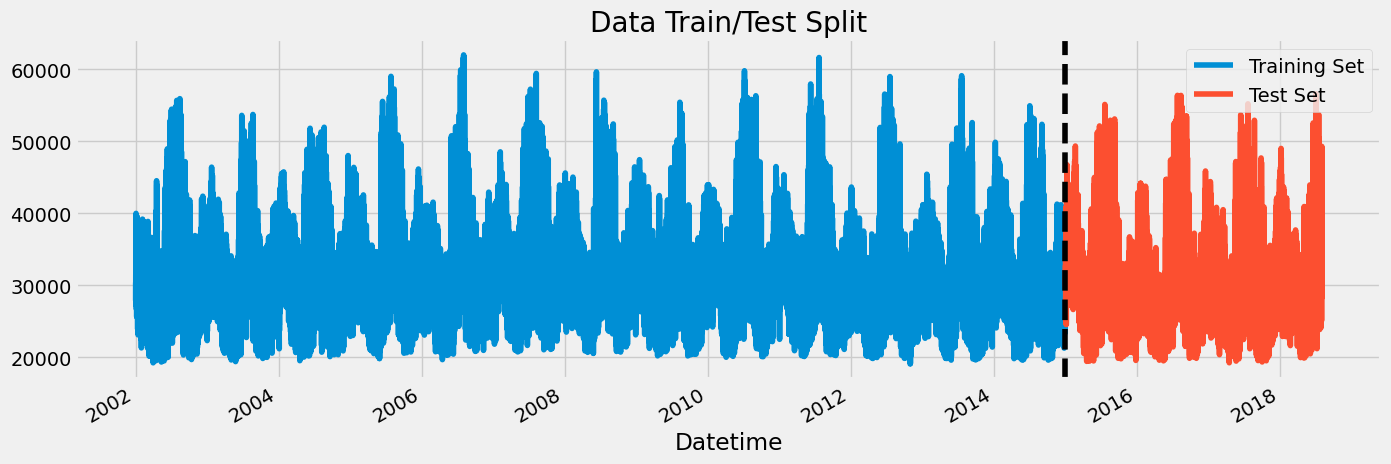

In [9]:
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

<div class="alert alert-block alert-warning">
<b>Note:</b> A more robust way to do this is actually to use time series cross validation. In <em>sklearn</em> we have the TimeSeriesSplit.
</div>

### Time Series Cross Validation

In [10]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24*30) 
# For the test_size let's say predict out into the future one year, gap is the distance between the training and test set
df = df.sort_index() # if the data is not sorted, the TimeSeriesSplit will not work

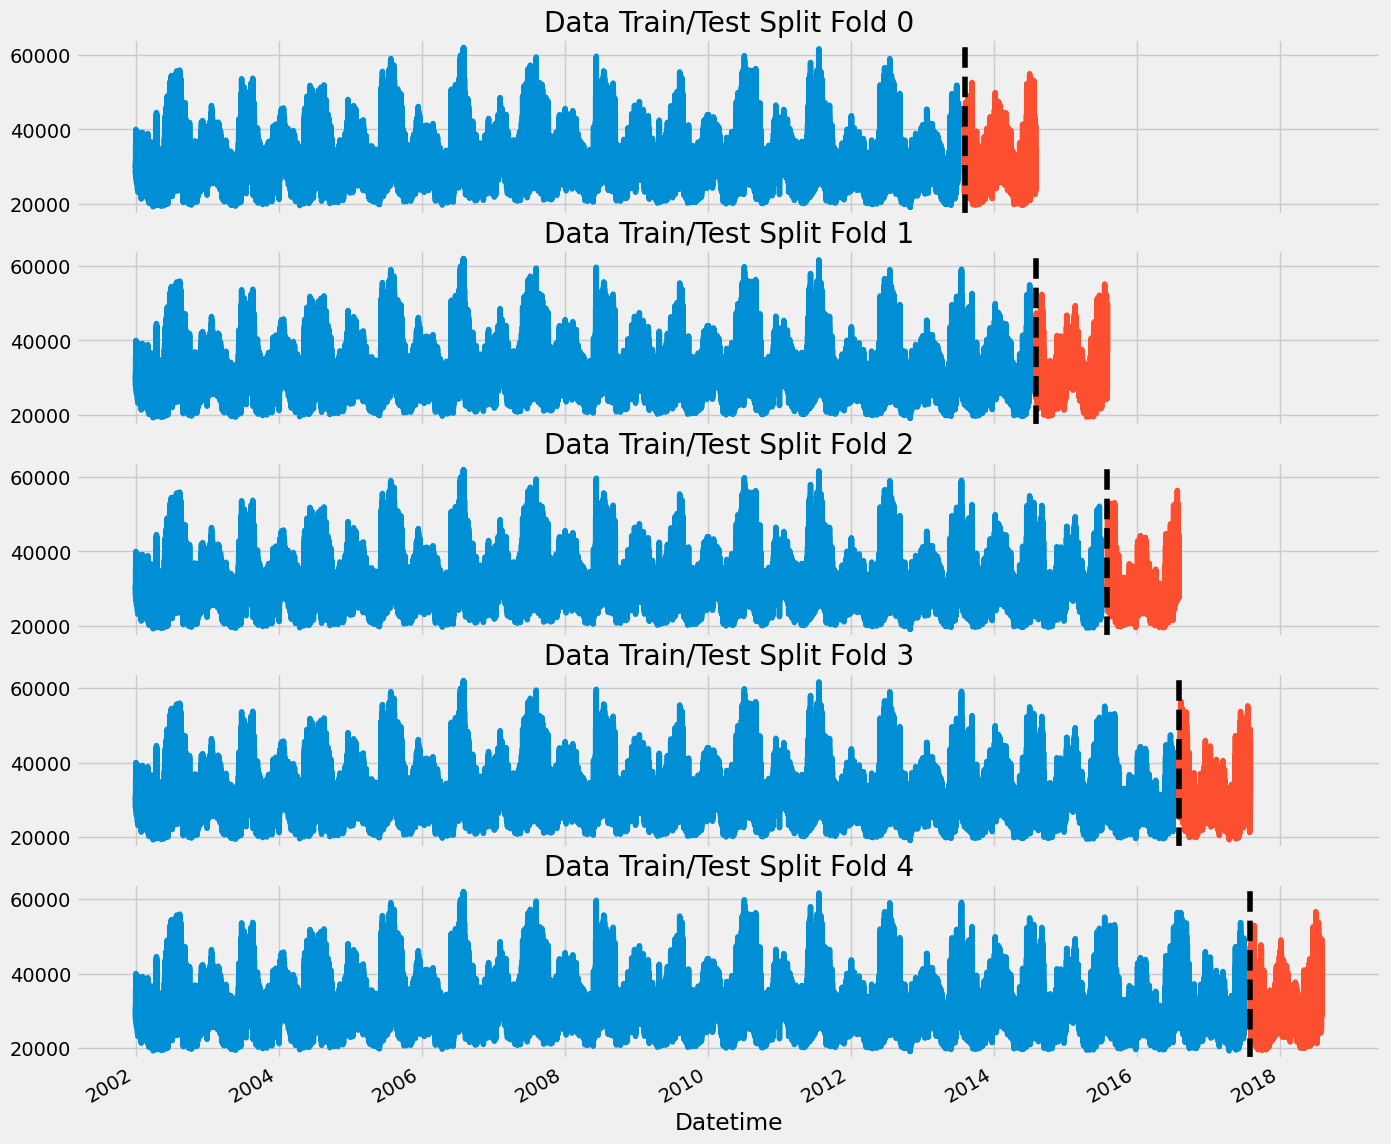

In [11]:
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True) # sharex=True will share the x axis between the plots

fold = 0 # fold number, keep track of the fold number or iteration in the loop
for train_idx, val_idx in tss.split(df): # train_idx and val_idx are the indexes of the training and test set
    train = df.iloc[train_idx] # iloc is used to index the dataframe by integer-location
    test = df.iloc[val_idx] 
    train['PJME_MW'].plot(ax=axs[fold], # plot the training set on the fold number 
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['PJME_MW'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1 # increment the fold number to move to the next plot
plt.show()

<p style="color: pink">We go back in time 5 times because we are actually testing each of the last 5 years independently from each other. When doing this CV we want to make sure we are as leak free as possible.
</p>

### Forecasting Horizon Explained
How far out into the future we want to predict? The forecast horizon is the length of time into the future for which forecasts are to be prepared. These generally vary from short-term forecasting horizons (less than three months) to long-term horizons (more than two years). The further out we get from the day we are predicting it's going to be harder to predict with accuracy.

In [12]:
def create_features(df):
    """
    Creates time series features from datetime index
    """
    df = df.copy() # We make a copy of the dataframe to avoid modifying the original dataframe
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek # Monday = 0, Sunday = 6, checked in pandas documentation
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month    
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    return df

df = create_features(df)

### Lag Features
We are telling the model to look back into the past, days in the past, and to use the target value for that many days int he past as a new feature we feed into the model. We will create a dictionary for mapping these lag features onto our dataframe 

In [13]:
def add_lags(df):
    target_map = df['PJME_MW'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map) # 364 days is one year because it's a leap year
    df['lag2'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('1092 days')).map(target_map)
    return df

In [14]:
df = add_lags(df)

In [16]:
df.head() # When going back to the beginning of the dataset, the lag are NaN because there is no data to go back to
df.tail() # while checking the end we see we have data to go back to

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,lag1,lag2,lag3
Datetime,,,,,,,,,,
2018-08-02 20:00:00,44057.0,20,3,3,8,2018,214,42256.0,41485.0,38804.0
2018-08-02 21:00:00,43256.0,21,3,3,8,2018,214,41210.0,40249.0,38748.0
2018-08-02 22:00:00,41552.0,22,3,3,8,2018,214,39525.0,38698.0,37330.0
2018-08-02 23:00:00,38500.0,23,3,3,8,2018,214,36490.0,35406.0,34552.0
2018-08-03 00:00:00,35486.0,0,4,3,8,2018,215,33539.0,32094.0,31695.0


<div class="alert alert-block alert-info">
<b>Note:</b> We can only forecast one year now because we are restricted with lag1 because once we look out into the future more than one year we don't know what that lag value is</div>

### Train Using Cross Validation
Let's put all together: we have our new lag features, our CV setup and we are going to loop over these different CV folds and train our model on the training and test set from the tss.split(df). Then we are going to score the model with MSE and save those scores in a list scores[]

In [17]:
tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
df = df.sort_index()


fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month','year',
                'lag1','lag2','lag3']
    TARGET = 'PJME_MW'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[0]	validation_0-rmse:32732.49608	validation_1-rmse:31956.60163


c:\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [10:15:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12532.64369	validation_1-rmse:11906.14134
[200]	validation_0-rmse:5747.92495	validation_1-rmse:5359.26490
[300]	validation_0-rmse:3872.48134	validation_1-rmse:3900.86965
[400]	validation_0-rmse:3434.23853	validation_1-rmse:3762.33705
[442]	validation_0-rmse:3369.34730	validation_1-rmse:3764.82810
[0]	validation_0-rmse:32672.16678	validation_1-rmse:32138.89241


c:\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [10:15:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12513.65574	validation_1-rmse:12224.93373
[200]	validation_0-rmse:5753.34937	validation_1-rmse:5662.07107
[300]	validation_0-rmse:3902.71304	validation_1-rmse:3933.73076
[400]	validation_0-rmse:3476.90515	validation_1-rmse:3590.55005
[500]	validation_0-rmse:3353.72424	validation_1-rmse:3516.39915
[600]	validation_0-rmse:3297.94766	validation_1-rmse:3481.94003
[700]	validation_0-rmse:3258.48267	validation_1-rmse:3461.37383
[800]	validation_0-rmse:3221.51553	validation_1-rmse:3436.49603
[900]	validation_0-rmse:3190.11480	validation_1-rmse:3428.88699
[999]	validation_0-rmse:3166.16314	validation_1-rmse:3420.31309
[0]	validation_0-rmse:32631.20370	validation_1-rmse:31073.29733


c:\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [10:15:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12499.28425	validation_1-rmse:11136.70202
[200]	validation_0-rmse:5750.81453	validation_1-rmse:4813.22087
[300]	validation_0-rmse:3917.04200	validation_1-rmse:3553.46419
[400]	validation_0-rmse:3494.55924	validation_1-rmse:3495.32356
[411]	validation_0-rmse:3475.26636	validation_1-rmse:3503.65414
[0]	validation_0-rmse:32528.44438	validation_1-rmse:31475.39670


c:\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [10:15:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12462.36581	validation_1-rmse:12020.28283
[200]	validation_0-rmse:5738.57925	validation_1-rmse:5796.45874
[300]	validation_0-rmse:3918.53218	validation_1-rmse:4388.39477
[400]	validation_0-rmse:3501.24270	validation_1-rmse:4173.36380
[500]	validation_0-rmse:3384.02490	validation_1-rmse:4119.56538
[600]	validation_0-rmse:3325.50024	validation_1-rmse:4105.01446
[700]	validation_0-rmse:3282.73755	validation_1-rmse:4091.23557
[800]	validation_0-rmse:3250.37610	validation_1-rmse:4083.12690
[900]	validation_0-rmse:3223.87814	validation_1-rmse:4081.46154
[999]	validation_0-rmse:3199.82843	validation_1-rmse:4052.57120
[0]	validation_0-rmse:32462.05557	validation_1-rmse:31463.90500


c:\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [10:15:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12445.87740	validation_1-rmse:11963.42706
[200]	validation_0-rmse:5752.44568	validation_1-rmse:5611.92884
[300]	validation_0-rmse:3951.51709	validation_1-rmse:4156.41403
[400]	validation_0-rmse:3539.25569	validation_1-rmse:4006.58873
[440]	validation_0-rmse:3479.88018	validation_1-rmse:4011.05271


In [18]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 3742.5833
Fold scores:[3760.8277187583353, 3420.313091887879, 3478.018038580526, 4052.5712055405547, 4001.186553933809]


<div class="alert alert-block alert-success">
Above we run five different experiments and we can see how the scores are for each five and ideally the more we start hyperparameter tuning the more features we add we want to see the scores get better across all of these folds so there are a few different ways of evaluating this but here we are just printing the average value using numpy the mean value of the scores and also each score individually this would be the CV score that we would be looking at 'Score across folds' to approve upon</div>

### Predicting the Future
- Retraining on all data
- To Predict the future we need an emtpy dataframe for future date ranges.
- Run those dates through our feature creation code + lag creation

In [19]:
# Retrain on all data
df = create_features(df)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year',
            'lag1','lag2','lag3']
TARGET = 'PJME_MW'

X_all = df[FEATURES] # We use all the data to train the model again but instead of X_train we use X_all
y_all = df[TARGET]

reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',    
                       n_estimators=500, # We decrease the number of estimators because around the 500 mark the model starts to overfit
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)

[0]	validation_0-rmse:32403.88991


c:\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [10:34:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12426.83220
[200]	validation_0-rmse:5751.73275
[300]	validation_0-rmse:3971.53256
[400]	validation_0-rmse:3571.21833
[499]	validation_0-rmse:3456.76877


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

In [20]:
df.index.max() # The last date in the dataset to predict the future below in range function

Timestamp('2018-08-03 00:00:00')

In [21]:
# Create future dataframe
future = pd.date_range('2018-08-03','2019-08-01', freq='1h') # We predict one year into the future from 2018-08-03 to 2019-08-01 and hourly with freq='1h'
future_df = pd.DataFrame(index=future) # We create a new dataframe with the future dates as the index
future_df['isFuture'] = True # We add a column to the future dataframe to differentiate between the future and the past
df['isFuture'] = False # We add a column to the original dataframe to differentiate between the future and the past
df_and_future = pd.concat([df, future_df])
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)

In [22]:
future_w_features = df_and_future.query('isFuture').copy()

In [25]:
future_w_features 

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,lag1,lag2,lag3,isFuture,pred
2018-08-03 00:00:00,NaN,0,4,3,8,2018,215,33539.0,32094.0,31695.0,True,30747.998047
2018-08-03 01:00:00,NaN,1,4,3,8,2018,215,30781.0,29503.0,29128.0,True,28575.041016
2018-08-03 02:00:00,NaN,2,4,3,8,2018,215,29015.0,27712.0,27373.0,True,27978.013672
2018-08-03 03:00:00,NaN,3,4,3,8,2018,215,27884.0,26535.0,26233.0,True,27365.339844
2018-08-03 04:00:00,NaN,4,4,3,8,2018,215,27223.0,25870.0,25643.0,True,26971.216797
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-07-31 20:00:00,NaN,20,2,3,7,2019,212,46912.0,39352.0,40243.0,True,42214.800781
2019-07-31 21:00:00,NaN,21,2,3,7,2019,212,45985.0,38699.0,39183.0,True,41461.097656
2019-07-31 22:00:00,NaN,22,2,3,7,2019,212,44094.0,37346.0,37759.0,True,40707.289062
2019-07-31 23:00:00,NaN,23,2,3,7,2019,212,40666.0,34555.0,34641.0,True,38414.546875


<p style="color: pink">Runing our future_w_features dataframe goes until 2019 with all the features we created except the target cause we are going to predict below.</p>

### Predict the Future

In [23]:
future_w_features['pred'] = reg.predict(future_w_features[FEATURES])

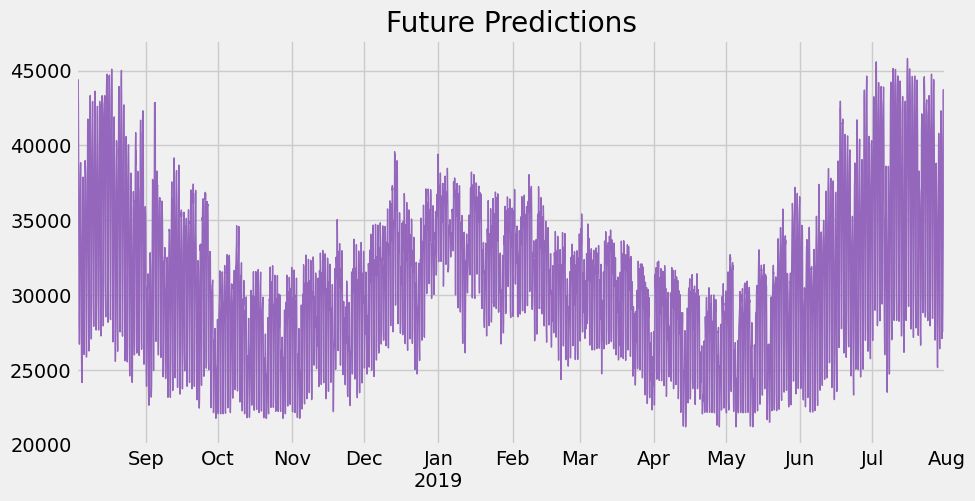

In [24]:
future_w_features['pred'].plot(figsize=(10, 5),
                               color=color_pal[4],
                               ms=1,
                               lw=1,
                               title='Future Predictions')
plt.show()

### Saving Model for Later
How we can save and reload the XGBoost model. Let's say we didn't want to retrain this every time we want to predict every new day or new hour so we can save this model very easily using the save model method on this regressor using the save_model() method as json 

In [27]:
# Save model
reg.save_model('C:/Users/Jorge Payà/Desktop/4Geeks/DSML Bootcamp/Time-Series-projects/models/model.json')

<p style="color: pink">This way we can load this back in using XGBoost regressor as we did before calling this for example as reg_new with load_model so we can run this and load in the same model we had before. So let's prove it by runing the same prediction as before:</p>

<Axes: title={'center': 'Future Predictions'}>

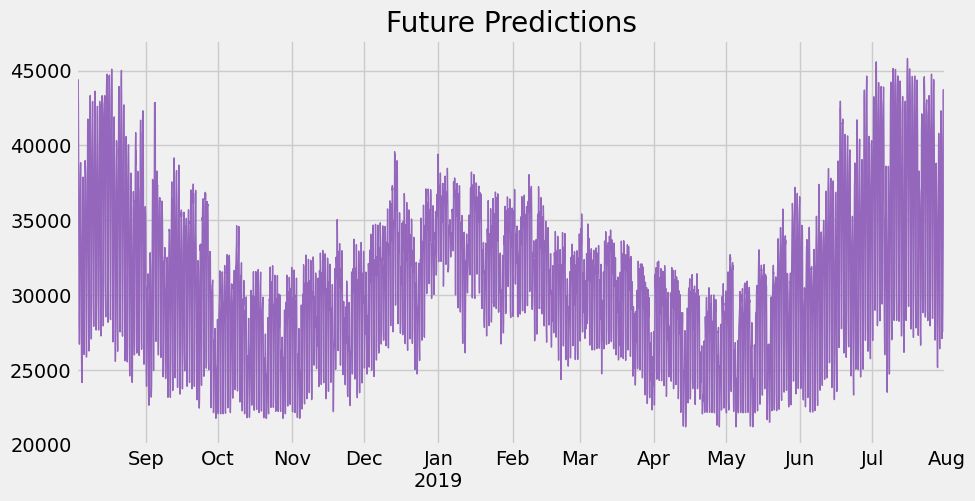

In [31]:
reg_new = xgb.XGBRegressor()
reg_new.load_model('C:/Users/Jorge Payà/Desktop/4Geeks/DSML Bootcamp/Time-Series-projects/models/model.json')
future_w_features['pred'] = reg_new.predict(future_w_features[FEATURES])
future_w_features['pred'].plot(figsize=(10, 5),
                               color=color_pal[4],
                               ms=1, lw=1,
                               title='Future Predictions')